In [1]:
'''
Select region here, NYC or LA.
'''
region = "NYC"

In [2]:
'''
Make a dictionary of yoga businesses listed on Yelp,
including their names, URL's, addresses & phone numbers.
'''
import urllib2
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pickle

yoga_biz_dict = {}
num_entry     = 0
base_url      = "http://www.yelp.com"
if region == "NYC":
    page_url = "/search?find_desc=Yoga&find_loc=New+York%2C+NY&ns=1#start=0&cflt=yoga"
else:
    page_url = "/search?find_desc=yoga&find_loc=Los+Angeles%2C+CA&ns=1#start=0&cflt=yoga"

# Make a dictionary of basic info for all yoga studios listed on Yelp for the selected region:
more_pages = True
while more_pages:
    page     = urllib2.urlopen(base_url+page_url)
    soup     = BeautifulSoup(page)
    for obj1 in soup.find_all("span",class_="indexed-biz-name"):
        biz_url     = ''
        biz_name    = ''
        biz_rating  = 0
        biz_reviews = 0
        biz_hood    = ''
        biz_address = ''
        biz_phone   = ''
        if obj1:
            obj2 = obj1.find_next("a")
            if obj2:
                obj3 = obj2.get("href")
                if obj3:
                    biz_url  = "http://www.yelp.com"+obj3
                biz_name = unicode(obj2.string).encode('ascii', 'replace')

            obj2        = obj1.find_next("div",class_="rating-large")
            if obj2:
                biz_rating  = float(obj2.find_next("i")['title'].split()[0])

            obj2        = obj1.find_next("span",class_="review-count rating-qualifier")
            if obj2:
                biz_reviews = int(obj2.string.split()[0])

            obj2        = obj1.find_next("span",class_="neighborhood-str-list")
            if obj2:
                biz_hood    = obj2.string.strip()

            obj2        = obj1.find_next("span",class_="biz-phone")
            if obj2:
                biz_phone   = obj2.string.strip()

            obj2        = obj1.find_next("div",class_="secondary-attributes")
            if obj2:
                for item in obj2.children:
                    obj3 = unicode(item).encode('ascii', 'replace')
                    if "<address>" in obj3:
                        biz_address = obj3.replace('<address>','').replace('</address>','')\
                                      .replace('<br>',', ').replace('</br>','').strip()
            num_entry += 1
            yoga_biz_dict[num_entry] = [biz_name,biz_url,biz_rating,biz_reviews,
                                        biz_hood,biz_address,biz_phone]
            
    obj1 = soup.find("a",class_="page-option prev-next next")
    if obj1:
        page_url = obj1.get("href")
    else:
        more_pages = False

print 'Number of yoga businesses scraped = %i' % num_entry

if region == "NYC":
    pkl_file = "NYC_yoga_businesses.pkl"
else:
    pkl_file = "LA_yoga_businesses.pkl"

with open( pkl_file, 'w' ) as f:
    pickle.dump(yoga_biz_dict, f)

Number of yoga businesses scraped = 1000


In [2]:
'''
Have a quick look at how many "unique" yoga businesses we picked up,
in terms of their names and url's.
'''
from pprint import pprint
import pickle

if region == "NYC":
    pkl_file = "NYC_yoga_businesses.pkl"
else:
    pkl_file = "LA_yoga_businesses.pkl"
    
with open( pkl_file, 'r' ) as f:
    yoga_biz_dict = pickle.load(f)
print 'Number of %s dictionary entries = %i' % (region,len(yoga_biz_dict))

yoga_biz       = set()
for key,value in yoga_biz_dict.items():
    yoga_biz.add(tuple(value))
print 'Number of %s yoga businesses =     %i' % (region,len(yoga_biz))

yoga_biz_urls = set()
for key,value in yoga_biz_dict.items():
    yoga_biz_urls.add(value[1])
print 'Number of %s yoga business urls =  %i' % (region,len(yoga_biz_urls))

yoga_biz_names = set()
for key,value in yoga_biz_dict.items():
    yoga_biz_names.add(value[0])
print 'Number of %s yoga business names = %i' % (region,len(yoga_biz_names))

#print yoga_biz_names

Number of NYC dictionary entries = 1000
Number of NYC yoga businesses =     860
Number of NYC yoga business urls =  796
Number of NYC yoga business names = 736


In [3]:
'''
Make a dictionary with yoga businesses that have a yelp url,
so we can fetch their reviews later.
'''
from pprint import pprint
import pickle

if region == "NYC":
    pkl_infile  = "NYC_yoga_businesses.pkl"
    pkl_outfile = "NYC_yoga_businesses_unique_urls.pkl"
else:
    pkl_infile  = "LA_yoga_businesses.pkl"
    pkl_outfile = "LA_yoga_businesses_unique_urls.pkl"
    
with open( pkl_infile, 'r' ) as f:
    yoga_biz_dict = pickle.load(f)
    
# Make a dictionary of yoga studios with unique url's
yoga_biz_url_dict = {}
for key1,value1 in yoga_biz_dict.items():
    url_len = len(yoga_biz_url_dict)
    already = False
    if url_len > 0:
        for key2,value2 in yoga_biz_url_dict.items():
            if value2[1] == value1[1]:
                already = True
                break
    if not already:
        yoga_biz_url_dict[key1] = value1

print 'Number of %s yoga businesses with unique urls = %i' % (region,len(yoga_biz_url_dict))

with open( pkl_outfile, 'w' ) as f:
    pickle.dump( yoga_biz_url_dict, f )

Number of NYC yoga businesses with unique urls = 796


In [16]:
'''
Here we scrape the pages with Yelp reviews for each of the yoga
businesses we collected previously.  The result of the scraping
is stored in MongoDB collections yyrnyc and yyrla.

Don't forget to run mongod before starting this.
'''
import urllib2
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pickle
from pymongo import MongoClient

client   = MongoClient()

if region == "NYC":
    yyr      = client.dsbc.yyrnyc
    pkl_file = "NYC_yoga_businesses_unique_urls.pkl"
else:
    yyr      = client.dsbc.yyrla
    pkl_file = "LA_yoga_businesses_unique_urls.pkl"

cursor   = yyr.find()
url_done = []
for record in cursor:
    url_done.append(record['biz_num'])
print 'Number or urls already in %s database = %i' % (region,len(url_done))

with open( pkl_file, 'r' ) as f:
    yoga_biz_url_dict = pickle.load(f)

nsave = 0
nurls = 0
for key,value in yoga_biz_url_dict.items():
    if key not in url_done:
        nurls += 1
        if nurls%10 == 1:
            print '%i: Now at yoga business %i: "%s"' % (nurls,key,value[0])
        review_num = 0
        nreviews   = value[3]
        review     = {}
        review['biz_num']     = key
        review['biz_name']    = value[0]
        review['biz_url']     = value[1]
        review['biz_rating']  = value[2]
        review['n_reviews']   = value[3]
        review['biz_hood']    = value[4]
        review['biz_address'] = value[5]
        review['biz_phone']   = value[6]
        review['biz_website'] = ""
        review['usr_id']      = []           
        review['usr_name']    = []
        review['usr_loc']     = []
        review['usr_friends'] = []
        review['usr_reviews'] = []
        review['usr_rating']  = []
        review['usr_pubdate'] = []
        review['usr_lang']    = []
        review['usr_text']    = []
        review['usr_useful']  = []
        review['usr_funny']   = []
        review['usr_cool']    = []

        base_url   = value[1]
        page_url   = base_url
        first_page = True
        more_pages = True
        while more_pages:
            page     = urllib2.urlopen(page_url)
            soup     = BeautifulSoup(page)
            
            if first_page:
                first_page = False
                obj1       = soup.find("div",class_="biz-website")
                if obj1:
                    review['biz_website'] = obj1.a.string

            for obj1 in soup.find_all("div",class_="review review--with-sidebar"):
                user_id     = ''
                author      = ''
                user_loc    = ''
                friend_cnt  = 0
                review_cnt  = 0
                rating      = ''
                pub_date    = ''
                language    = ''
                description = ''
                useful      = 0
                funny       = 0
                cool        = 0
                if obj1:
                    try:
                        user_id = obj1["data-signup-object"].replace("user_id:","")
                    except:
                        print 'data-signup-object/user_id error at %s' % page_url
                    else:
                        obj2 = obj1.find_next("meta",itemprop="author")
                        if obj2:
                            author = obj2["content"]
                        obj2 = obj1.find_next("li",class_="user-location")
                        if obj2:
                            user_loc = obj2.b.string
                        obj2 = obj1.find_next("li", class_="friend-count")
                        if obj2:
                            friend_cnt = int(obj2.span.b.string)
                        obj2 = obj1.find_next("li", class_="review-count")
                        if obj2:
                            review_cnt = int(obj2.span.b.string)
                        obj2 = obj1.find_next("meta",itemprop="ratingValue")
                        if obj2:
                            rating = obj2["content"]
                        obj2 = obj1.find_next("meta",itemprop="datePublished")
                        if obj2:
                            pub_date = obj2["content"]
                        obj2 = obj1.find_next("p",itemprop="description")
                        if obj2:
                            language = obj2["lang"]
                            for string in obj2.strings:
                                description = description + string
                        obj2 = obj1.find_next("a",class_="ybtn ybtn-small useful")
                        if obj2:
                            obj3 = obj2.find_next("span",class_="count")
                            if obj3:
                                if obj3.string:
                                    useful = int(obj3.string)
                        obj2 = obj1.find_next("a",class_="ybtn ybtn-small funny")
                        if obj2:
                            obj3 = obj2.find_next("span",class_="count")
                            if obj3:
                                if obj3.string:
                                    funny = int(obj3.string)
                        obj2 = obj1.find_next("a",class_="ybtn ybtn-small cool")
                        if obj2:
                            obj3 = obj2.find_next("span",class_="count")
                            if obj3:
                                if obj3.string:
                                    cool = int(obj3.string)
                        # Avoid saving duplicate reviews:
                        if description not in review['usr_text']:
                            review_num += 1
                            review['usr_id'].append(user_id)            
                            review['usr_name'].append(author)
                            review['usr_loc'].append(user_loc)
                            review['usr_friends'].append(friend_cnt)
                            review['usr_reviews'].append(review_cnt)
                            review['usr_rating'].append(rating)
                            review['usr_pubdate'].append(pub_date)
                            review['usr_lang'].append(language)
                            review['usr_text'].append(description)
                            review['usr_useful'].append(useful)
                            review['usr_funny'].append(funny)
                            review['usr_cool'].append(cool)
                    
            obj1 = soup.find("a",class_="page-option prev-next next")
            if obj1:
                page_url = obj1.get("href")
            else:
                more_pages = False
                
        if review_num != nreviews:
            print 'At yoga business %i, "%s": reviews expected = %i, found = %i' \
                    % (key,value[0],nreviews,review_num)
            review['n_reviews'] = review_num

        yyr.save(review)
        nsave += 1
            
print 'Number of records added to the database: %i' % nsave

Number or urls already in NYC database = 560
1: Now at yoga business 288: "Yoga Studio"
At yoga business 288, "Yoga Studio": reviews expected = 1, found = 0
At yoga business 305, "Yoga Fit For Life": reviews expected = 35, found = 0
At yoga business 313, "Spring Into Yoga": reviews expected = 4, found = 0
At yoga business 327, "Verde Yoga": reviews expected = 9, found = 0
At yoga business 329, "Shri Yoga": reviews expected = 71, found = 0
At yoga business 331, "Catcow Yoga & Healing": reviews expected = 17, found = 0
At yoga business 332, "Maggie Studio, Inc": reviews expected = 17, found = 0
At yoga business 341, "Ashay Yoga": reviews expected = 4, found = 0
At yoga business 345, "The Healing Routes": reviews expected = 2, found = 0
At yoga business 349, "YogaRoni": reviews expected = 3, found = 0
11: Now at yoga business 352: "Shala Yoga"
At yoga business 352, "Shala Yoga": reviews expected = 5, found = 0
At yoga business 354, "Yoga at Sunset Park Rec Center": reviews expected = 1, f

In [7]:
'''
This is to delete from a yyr Mongo collection any yoga studio entries that
have no reviews.
'''
from pymongo import MongoClient

client   = MongoClient()

if region == "NYC":
    yyr = client.dsbc.yyrnyc
else:
    yyr = client.dsbc.yyrla
    
print 'Number of %s database entries = %i' % (region,yyr.count())
cursor   = yyr.find()
remover  = []
n_empty  = 0
for record in cursor:
    n_reviews = len(record['usr_text'])
    if n_reviews == 0:
        n_empty += 1
        key      = record["_id"]
        remover.append(key)
print 'Number of %s businesses without review = %i' % (region,n_empty)

for key in remover:
    yyr.remove({"_id":key})
print 'Number of %s database entries = %i' % (region,yyr.count())

Number of NYC database entries = 550
Number of NYC businesses without review = 0
Number of NYC database entries = 550


Number of yoga businesses in database = 796
Business "Yoga Agora [at] 33-02 Broadway, Astoria, NY 11106" has 165 reviews
Business "Yoga Vida [at] 99 University Pl, New York, NY 10003" has 130 reviews
Business "Yoga to the People [at] 12 St. Marks Pl, New York, NY 10003" has 331 reviews
Business "Bikram Yoga Lower East Side [at] 172 Allen St, New York, NY 10002" has 134 reviews
Business "Jivamukti Yoga School [at] 841 Broadway, New York, NY 10003" has 128 reviews
Business "Exhale Central Park South [at] 150 Central Park S, New York, NY 10019" has 146 reviews

Number of businesses with 0 reviews = 236
Number of businesses with at least 1,2,3,10,100 reviews = 560, 464, 398, 221, 10
Number of discrepancies = 0
Total number of reviews in database = 9324


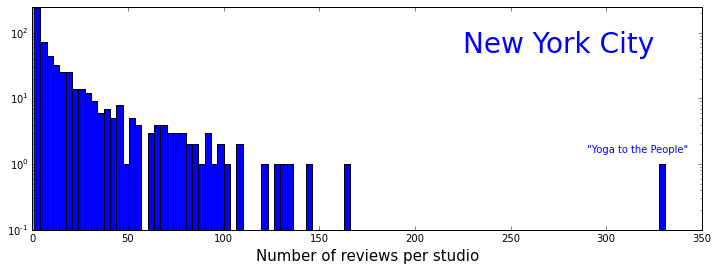

In [17]:
'''
Let's look at what we have in MongoDB, collection yyrnyc in database dsbc.
'''
%matplotlib inline
from pymongo import MongoClient
import matplotlib.pyplot as plt

client   = MongoClient()
yyr      = client.dsbc.yyrnyc  # New York City area
print 'Number of yoga businesses in database = %i' % yyr.count()
cursor   = yyr.find()

n0       = 0
n1       = 0
n2       = 0
n3       = 0
n10      = 0
n100     = 0
ndis     = 0
nrlistnyc= []
rtotal   = 0
rlengths = []
for record in cursor:
    for review in record['usr_text']:
        rlengths.append(len(review))
    nreviews = len(record['usr_text'])
    rtotal  += nreviews
    if nreviews != 0: nrlistnyc.append(nreviews)
    if nreviews > 99: 
        n100 += 1
    if nreviews > 120:
        print 'Business "%s [at] %s" has %i reviews' \
        % (record['biz_name'],record['biz_address'],nreviews)
    if nreviews > 9:   n10 += 1
    if nreviews > 2:    n3 += 1
    if nreviews > 1:    n2 += 1
    if nreviews > 0:    n1 += 1
    if nreviews == 0:   n0 += 1
    if nreviews != record['n_reviews']: 
        ndis += 1
        print 'For business "%s" we expected %i reviews, found %i' \
        %(record['biz_name'],record['n_reviews'],nreviews)

print
print 'Number of businesses with 0 reviews = %i' % n0
print 'Number of businesses with at least 1,2,3,10,100 reviews = %i, %i, %i, %i, %i' \
% (n1,n2,n3,n10,n100)
print 'Number of discrepancies = %i' % ndis
print 'Total number of reviews in database = %i' % rtotal

# Histogram the number of reviews per studio, for studios with at least one review:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistnyc, color='b', bins=100 )
ax.set_xlabel('Number of reviews per studio', fontsize=15)
ax.set_ylim(0.1,250.0)
ax.set_yscale('log')
ax.text(225.0,50.0,"New York City",size=28,color='b')
ax.text(290.0,1.5,'"Yoga to the People"',size=10,color='b')
plt.show()
#fig.savefig("n_reviews_nyc.pdf")

Number of yoga businesses in database = 749
Business "Modo Yoga LA [at] 340 S La Brea Ave, Los Angeles, CA 90036" has 185 reviews
Business "Liberation Yoga [at] 124 S La Brea Ave, Los Angeles, CA 90036" has 135 reviews
Business "YogaWorks [at] 230 1/2 N Larchmont Blvd, Los Angeles, CA 90004" has 138 reviews
Business "Earth?s Power Yoga Center [at] 7901 Melrose Ave, Los Angeles, CA 90046" has 127 reviews
Business "The Raven Spa [at] 2910 Rowena Ave, Los Angeles, CA 90039" has 230 reviews
Business "Bikram Yoga Downtown LA [at] 700 W 1st St, Los Angeles, CA 90012" has 180 reviews
Business "The Springs [at] 608 Mateo St, Los Angeles, CA 90021" has 150 reviews
Business "CorePower Yoga [at] 11819 Wilshire Blvd., Los Angeles, CA 90025" has 135 reviews
Business "Bikram Yoga Silverlake [at] 3223 Glendale Blvd, Los Angeles, CA 90039" has 251 reviews
Business "Pop Physique [at] 3501 W Sunset Blvd, Los Angeles, CA 90026" has 175 reviews
Business "YAS Silverlake [at] 1932 Hyperion Ave, Los Angeles,

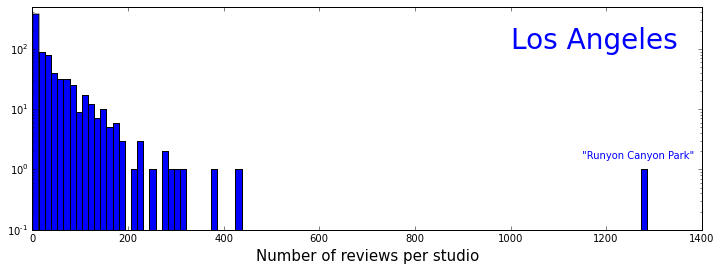

In [13]:
'''
Let's look at what we have in MongoDB, collection yyrla in database dsbc.
'''
%matplotlib inline
from pymongo import MongoClient
import matplotlib.pyplot as plt

client   = MongoClient()
yyr      = client.dsbc.yyrla  # Los Angeles area
print 'Number of yoga businesses in database = %i' % yyr.count()
cursor   = yyr.find()

n0       = 0
n1       = 0
n2       = 0
n3       = 0
n10      = 0
n100     = 0
ndis     = 0
nrlistla = []
rtotal   = 0
rlengths = []
for record in cursor:
    for review in record['usr_text']:
        rlengths.append(len(review))
    nreviews = len(record['usr_text'])
    rtotal  += nreviews
    if nreviews != 0: nrlistla.append(nreviews)
    if nreviews > 99: 
        n100 += 1
    if nreviews > 120:
        print 'Business "%s [at] %s" has %i reviews' \
        % (record['biz_name'],record['biz_address'],nreviews)
    if nreviews > 9:   n10 += 1
    if nreviews > 2:    n3 += 1
    if nreviews > 1:    n2 += 1
    if nreviews > 0:    n1 += 1
    if nreviews == 0:   n0 += 1
    if nreviews != record['n_reviews']: 
        ndis += 1
        print 'For business "%s" we expected %i reviews, found %i' \
        %(record['biz_name'],record['n_reviews'],nreviews)

print
print 'Number of businesses with 0 reviews = %i' % n0
print 'Number of businesses with at least 1,2,3,10,100 reviews = %i, %i, %i, %i, %i' \
% (n1,n2,n3,n10,n100)
print 'Number of discrepancies = %i' % ndis
print 'Total number of reviews in database = %i' % rtotal

# Histogram number of reviews per studio, for studios with at least one review:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistla, color='b', bins=100 )
ax.set_xlabel('Number of reviews per studio', fontsize=15)
ax.set_ylim(0.1,500.0)
ax.set_yscale('log')
ax.text(1000.0,100.0,"Los Angeles",size=28,color='b')
ax.text(1150.0,1.5,'"Runyon Canyon Park"',size=10,color='b')
plt.show()
# fig.savefig("n_reviews_la.pdf")

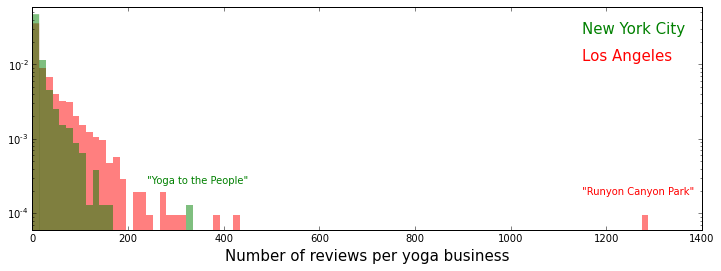

In [14]:
'''
Using nrlistnyc and nrlistla obtained in the previous two cells, make a histogram
of the number of reviews per studio, for studios with at least one review,
superimposing the NYC and LA results with different colors.
'''
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,4) )
ax.hist( nrlistla,  color='r', edgecolor='none', bins=100, range=[0.0,1400.0], \
         normed=True, alpha=0.5)
ax.hist( nrlistnyc, color='g', edgecolor='none', bins=100, range=[0.0,1400.0], \
         normed=True, alpha=0.5 )
ax.set_xlabel('Number of reviews per yoga business', fontsize=15)
ax.set_ylim(0.00006,0.06)
ax.set_yscale('log')
ax.text( 1150.0, 0.030, "New York City", ha='left', va='center', size=15, color='g')
ax.text( 1150.0, 0.013, "Los Angeles", ha='left', va='center', size=15, color='r')
ax.text( 1150.0, 0.00018, '"Runyon Canyon Park"', size=10, color='r')
ax.text(  240.0, 0.00025, '"Yoga to the People"', size=10, color='g')
plt.show()
fig.savefig("n_reviews_nyc_la.pdf")